In [1]:
from dataset import Dataset
dataset = Dataset()
import vectorbt as vbt
import numpy as np
import warnings
import pandas as pd
from datetime import datetime, timedelta
warnings.simplefilter(action='ignore')


In [2]:
TICKER = 'BTCUSDT'
data_binance = Dataset().get_data(days=360, ticker=TICKER, ts='5m')


In [3]:

# Save the data to CSV if it hasn't been saved before
csv_file_path = 'data/5m.csv'
data_binance.to_csv(csv_file_path, index=False)

In [4]:
# Load the data from CSV (in case it's already saved)
data_binance = pd.read_csv(csv_file_path)

In [5]:
data = data_binance.copy()


In [6]:
data['Middle Band'] = data['close'].rolling(window=5).mean()
data['Upper Band'] = data['Middle Band'] + 1.96*data['close'].rolling(window=5).std()
data['Lower Band'] = data['Middle Band'] - 1.96*data['close'].rolling(window=5).std()


<Axes: >

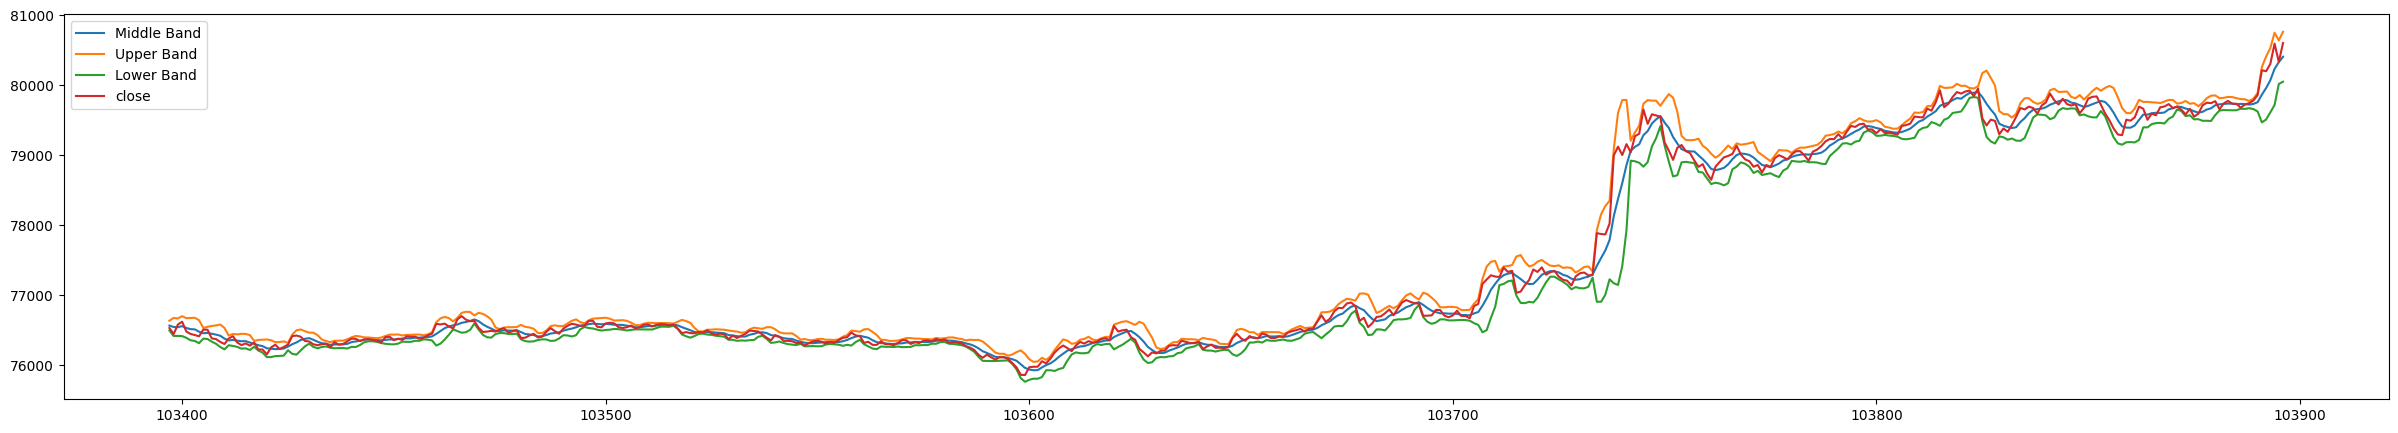

In [7]:
data.tail(500)[['Middle Band', 'Upper Band', 'Lower Band', 'close']].plot(figsize=(30, 5))



In [8]:
# Assuming 'data' already has a 'close' column from your price data
# Sample data for demonstration; replace this with your actual data load if needed
data = pd.DataFrame({
    'close': np.random.rand(100) * 100  # Simulate close prices
})

# Prepare best parameters list to store the optimal parameters
best_parameters = []

# Define the parameter ranges
windows = range(1, 50, 10)
lags = range(1, 50, 10)
trail = [0.001, 0.003, 0.005]
tp_profits = [0.002, 0.004, 0.006, 0.008]
sl_losses = [0.002, 0.004, 0.006, 0.008]

# Start iterating over parameter combinations
for window in windows:
    for lag in lags:
        for tp in tp_profits:
            for sl in sl_losses:
                for tr in trail:
                    # Calculate Bollinger Bands
                    data['Middle Band'] = data['close'].rolling(window=window).mean()
                    data['Upper Band'] = data['Middle Band'] + 1.96 * data['close'].rolling(window=window).std()
                    data['Lower Band'] = data['Middle Band'] - 1.96 * data['close'].rolling(window=window).std()

                    # Define entries and exits for long and short positions
                    data['entries_long'] = np.where(data['close'] < data['Lower Band'], True, False)
                    data['exits_long'] = np.where(data['entries_long'].shift(lag), True, False)
                    data['entries_short'] = np.where(data['close'] > data['Upper Band'], True, False)
                    data['exits_short'] = np.where(data['entries_short'].shift(lag), True, False)

                    # Portfolio backtest
                    pf = vbt.Portfolio.from_signals(
                        sl_stop=sl,
                        tp_stop=tp,
                        sl_trail=tr,
                        close=data['close'],
                        entries=data['entries_long'],
                        exits=data['exits_long'],
                        short_entries=data['entries_short'],
                        short_exits=data['exits_short'],
                        direction='both',
                        accumulate=True
                    )

                    # Check stats and save if profitable
                    stats = pf.stats()
                    if stats['Profit Factor'] > 1.2:
                        print(f'lag: {lag}, window: {window}, sl: {sl}, tp: {tp}, tr: {tr}, return: {stats["Total Return [%]"]}')
                        best_parameters.append({
                            'lag': lag,
                            'window': window,
                            'sl': sl,
                            'tp': tp,
                            'tr': tr,
                            'stat': stats
                        })

# Save the best parameters to a CSV instead of pickle
best_parameters_df = pd.DataFrame(best_parameters)

# Save to CSV (replace pickle with CSV)
best_parameters_df.to_csv('data/best_parameters.csv', index=False)

print("Best parameters saved to data/best_parameters.csv.")


lag: 1, window: 11, sl: 0.002, tp: 0.002, tr: 0.001, return: 7529.511061213561
lag: 1, window: 11, sl: 0.002, tp: 0.002, tr: 0.003, return: 7529.511061213561
lag: 1, window: 11, sl: 0.002, tp: 0.002, tr: 0.005, return: 7529.511061213561
lag: 1, window: 11, sl: 0.004, tp: 0.002, tr: 0.001, return: 7529.511061213561
lag: 1, window: 11, sl: 0.004, tp: 0.002, tr: 0.003, return: 7529.511061213561
lag: 1, window: 11, sl: 0.004, tp: 0.002, tr: 0.005, return: 7529.511061213561
lag: 1, window: 11, sl: 0.006, tp: 0.002, tr: 0.001, return: 7529.511061213561
lag: 1, window: 11, sl: 0.006, tp: 0.002, tr: 0.003, return: 7529.511061213561
lag: 1, window: 11, sl: 0.006, tp: 0.002, tr: 0.005, return: 7529.511061213561
lag: 1, window: 11, sl: 0.008, tp: 0.002, tr: 0.001, return: 7529.511061213561
lag: 1, window: 11, sl: 0.008, tp: 0.002, tr: 0.003, return: 7529.511061213561
lag: 1, window: 11, sl: 0.008, tp: 0.002, tr: 0.005, return: 7529.511061213561
lag: 1, window: 11, sl: 0.002, tp: 0.004, tr: 0.001,

In [9]:
# Define the parameters for Bollinger Bands and trading strategy
window = 11  # Rolling window size for calculating moving average and standard deviation (Bollinger Bands)
lag = 31  # The lag for exit signals (i.e., how many periods after entry to exit)
sl = 0.008  # Stop loss percentage for trades
tp = 0.006  # Take profit percentage for trades
tr = 0.005  # Trailing stop percentage

# Calculate Bollinger Bands
# The middle band is the rolling mean of the close prices over a specified window
data['Middle Band'] = data['close'].rolling(window=window).mean()

# The upper band is the middle band + 1.96 times the rolling standard deviation (typically used for 95% confidence)
data['Upper Band'] = data['Middle Band'] + 1.96 * data['close'].rolling(window=window).std()

# The lower band is the middle band - 1.96 times the rolling standard deviation
data['Lower Band'] = data['Middle Band'] - 1.96 * data['close'].rolling(window=window).std()

# Define entries and exits for long and short positions with revised exit conditions

# For long entries, a trade is entered when the close price is below the lower band (price drops below the lower threshold)
data['entries_long'] = np.where(data['close'] < data['Lower Band'], True, False)

# For long exits, the position is exited when the price reaches or exceeds the middle band after the specified lag
data['exits_long'] = np.where(data['entries_long'].shift(lag), True, False)  # Exit when price reaches or exceeds the middle band

# For short entries, a trade is entered when the close price is above the upper band (price rises above the upper threshold)
data['entries_short'] = np.where(data['close'] > data['Upper Band'], True, False)

# For short exits, the position is exited when the price reaches or falls below the middle band after the specified lag
data['exits_short'] = np.where(data['entries_short'].shift(lag), True, False)  # Exit when price reaches or falls below the middle band

# Backtest the strategy using vectorbt
# The 'from_signals' function creates a portfolio based on the entry and exit signals for both long and short positions
pf = vbt.Portfolio.from_signals(
    sl_stop=sl,  # Set the stop loss for the portfolio
    tp_stop=tp,  # Set the take profit for the portfolio
    sl_trail=tr,  # Set the trailing stop for the portfolio
    close=data['close'],  # Use the close price data for calculations
    entries=data['entries_long'],  # Define long entries based on the condition
    exits=data['exits_long'],  # Define long exits based on the condition
    short_entries=data['entries_short'],  # Define short entries based on the condition
    short_exits=data['exits_short'],  # Define short exits based on the condition
    direction='both',  # Allow both long and short positions in the portfolio
    accumulate=True  # Enable continuous re-entry into positions once exited
)



In [10]:
pf.stats()


Start                            0.000000
End                             99.000000
Period                         100.000000
Start Value                    100.000000
End Value                     7629.511061
Total Return [%]              7529.511061
Benchmark Return [%]             5.098865
Max Gross Exposure [%]         100.000000
Total Fees Paid                  0.000000
Max Drawdown [%]                      NaN
Max Drawdown Duration                 NaN
Total Trades                     1.000000
Total Closed Trades              1.000000
Total Open Trades                0.000000
Open Trade PnL                   0.000000
Win Rate [%]                   100.000000
Best Trade [%]                7529.511061
Worst Trade [%]               7529.511061
Avg Winning Trade [%]         7529.511061
Avg Losing Trade [%]                  NaN
Avg Winning Trade Duration       1.000000
Avg Losing Trade Duration             NaN
Profit Factor                         inf
Expectancy                    7529

In [11]:
pf.plot()


FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'b917b562-dbab-4529-9244-92d3de686727',
              'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                          36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
                          54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
                          72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
                          90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int64),
              'xaxis': 'x',
              'y': array([79.9355459 , 36.86334694, 18.77901724, 62.86286786,  3.00608584,
                          44.87011546, 95.13961364, 33.483

In [12]:
pf.trades.records  # Shows a DataFrame with detailed trade records


,id,col,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl,return,direction,status,parent_id
0,0,0,99.20611,40,1.008002,0.0,41,76.905657,0.0,7529.511061,75.295111,0,1,0
